In [1]:
import pandas as pd
import numpy as np

#Plots
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
#Nicer style
style.use('seaborn') 

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

#Work with text
from nltk.tokenize import RegexpTokenizer
import re #regexp
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 




#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

import random

# Getting Real About Fake News
## Descripción del dataset

Este conjunto de datos se encuentra disponible en la plataforma Kaggle. Es el segundo más com- pleto utilizado ya que, aunque sólo posee 13000 noticias, éstas están categorizadas de una manera similar a las que se encuentran en el "Fake News Corpus".

El corpus ha sido construido mediante la recolección de datos automática (web scraping) en 244 sitios web durante 30 días por medio de una API externa. Sobre los datos recogidos se ha utilizado una extensión de navegador, ”BS Detector”

* **Fake News (tag fake)** Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports

* **Satire (tag satire)** Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events.

* **Extreme Bias (tag bias)** Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts.

* **Conspiracy Theory (tag conspiracy):** Sources that are well-known promoters of kooky conspiracy theories.

* **Rumor Mill (tag rumor)** Sources that traffic in rumors, gossip, innuendo, and unverified claims.

* **State News (tag state)** Sources in repressive states operating under government sanction.

* **Junk Science (tag junksci)** Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims.

* **Hate News (tag hate)** Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination.


### Cargamos el dataset.

In [2]:
news = pd.read_csv('../../data/Other_datasets/GettingRealAboutFake/fake.csv', nrows=20000)
news = news[['title', 'text', 'type']]
news = news.dropna()
news.head(3)

,title,text,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,bias
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,bias
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,bias


In [3]:
news.groupby('type')['type'].count()

type
bias            354
bs            10919
conspiracy      412
fake             19
hate            246
junksci         102
satire          100
state           121
Name: type, dtype: int64

*Convertir tags la división usada*

In [4]:
def convert_tag(tag):
    """Convierte un tag a uno de tres grupos (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['bs', 'state', 'conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'unreliable', 'fake'])
    bias = set(['bias'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in bias:
        new_tag = 'bias'
        
    return new_tag

In [5]:
news['type'] = news.swifter.apply(lambda row: convert_tag(row['type']), axis=1)

Pandas Apply: 100%|██████████| 12273/12273 [00:00<00:00, 69771.47it/s]


In [6]:
news.head(3)

,title,text,type
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,bias
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,bias
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,bias


Adjuntamos un porcentaje de noticias verdaderas desde FNC

In [7]:
true_news = pd.read_csv("../../data/Other_datasets/GettingRealAboutFake/news_only_true.csv", nrows=10000)
true_news['type'] = 'true'
true_news = true_news[['title', 'content', 'type']]
true_news = true_news.rename(str, columns={"content": "text"})
news = pd.concat([news, true_news])
news = news.sample(frac=1).reset_index(drop=True)

### Número de noticias por tipo

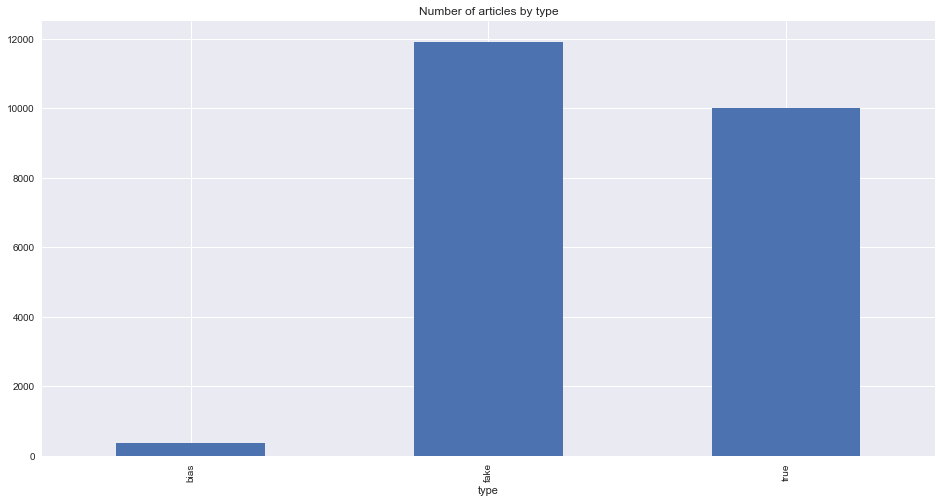

In [8]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.groupby("type")['type'].count().plot.bar(title = "Number of articles by type", ax = ax)

El grupo fake está claramente sobrerrepresentado en el dataset, mientras que el que menos elementos tiene es el grupo *bias*

# Análisis lingüístico

Funciones auxiliares

In [9]:
stop_words = STOPWORDS.union(set(["will"]))
ps = PorterStemmer()

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]    
    
    return ' '.join(words)


def clean_text_array(text):
    """ Lo mismo que clean_text pero retorna un array
    """
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words


def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens


def split_phrases(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = '. '.join(text.split("\n")).split(".")
    text = [x for x in text if x not in [".", "\n", "", " "]]
    return text

### Palabras más frecuentes por tipo de noticia

#### En el título

In [10]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'true']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'bias']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_bias= c.most_common(20)

In [11]:
most_common_bias

[('trump', 148),
 ('clinton', 48),
 ('hillary', 47),
 ('daily', 27),
 ('wire', 27),
 ('election', 26),
 ('donald', 20),
 ('new', 19),
 ('obama', 18),
 ('fbi', 17),
 ('comey', 16),
 ('email', 15),
 ('gop', 14),
 ('campaign', 13),
 ('media', 13),
 ('democrats', 11),
 ('calls', 9),
 ('black', 9),
 ('info', 9),
 ('know', 9)]

In [12]:
most_common_truth

[('daily', 1277),
 ('kos', 1197),
 ('trump', 661),
 ('profile', 376),
 ('articles', 368),
 ('obama', 261),
 ('comments', 253),
 ('people', 253),
 ('new', 242),
 ('followed', 240),
 ('news', 169),
 ('gop', 161),
 ('national', 161),
 ('favorite', 156),
 ('house', 151),
 ('blogs', 150),
 ('stream', 143),
 ('bill', 134),
 ('history', 131),
 ('review', 122)]

In [13]:
most_common_fake

[('trump', 1579),
 ('hillary', 1209),
 ('clinton', 1073),
 ('election', 558),
 ('us', 526),
 ('new', 500),
 ('news', 425),
 ('russia', 412),
 ('fbi', 402),
 ('war', 390),
 ('comment', 387),
 ('america', 363),
 ('obama', 340),
 ('world', 336),
 ('donald', 294),
 ('now', 278),
 ('wikileaks', 219),
 ('emails', 211),
 ('breaking', 208),
 ('campaign', 207)]

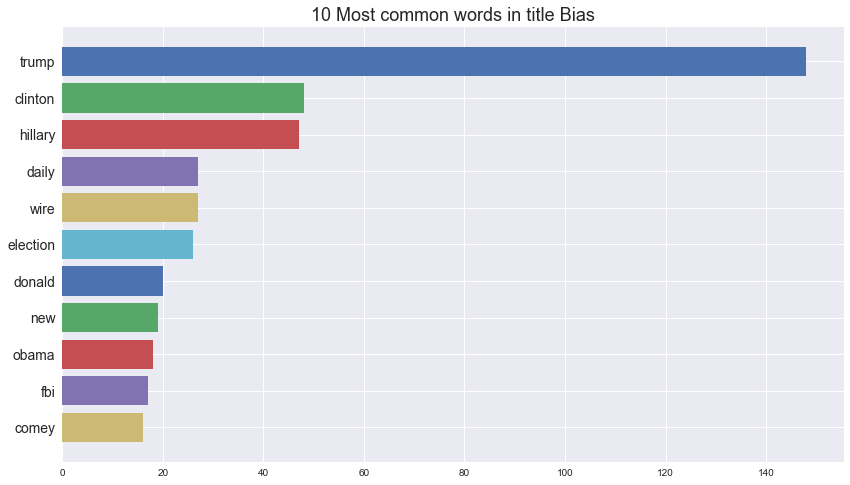

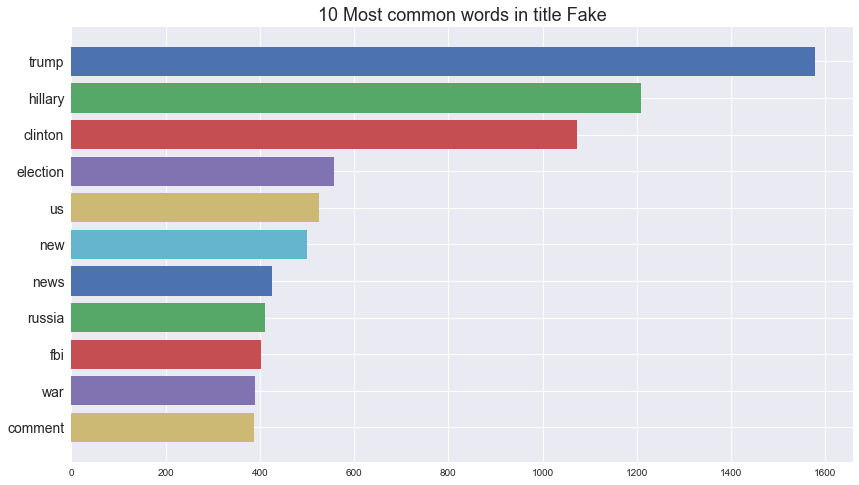

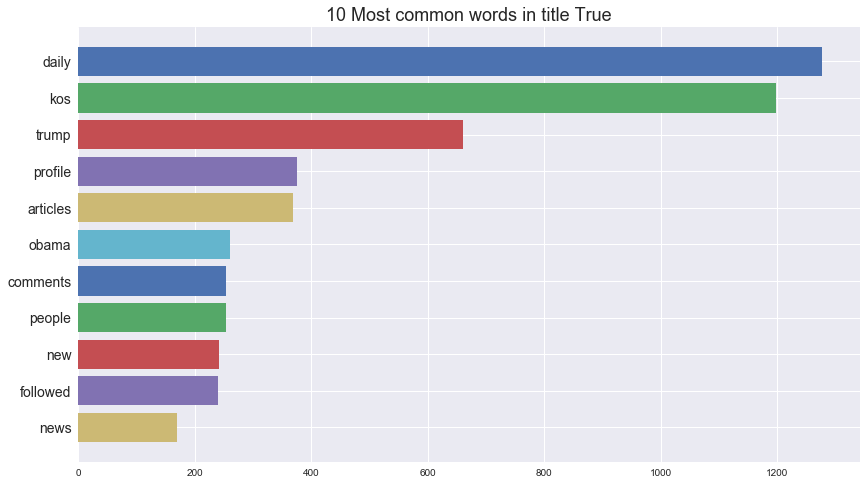

In [15]:
names = ["10 Most common words in title Bias", "10 Most common words in title Fake", "10 Most common words in title True"]
variables = [most_common_bias, most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

__Análisis de tri-grams__

In [18]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [19]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'true']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [20]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'bias']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_bias = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_bias[ng_text] = ng_count

In [21]:
print("TRIGRAMS BIAS")
ngrams_bias

TRIGRAMS BIAS


{'you need to': 8,
 'the knowledge you': 8,
 'need to know': 8,
 'knowledge you crave': 8,
 'info the knowledge': 8,
 'addicting info the': 8,
 'to know about': 6,
 'things you need': 6,
 'fbi director james': 4,
 'director james comey': 4,
 'clinton email investigation': 4,
 'youtube bans black': 2,
 'yes creationists can': 2,
 'would jesus christ': 2,
 'world wildlife by': 2,
 'women and minorities': 2,
 'woman alive by': 2,
 'will it be': 2,
 'wildlife by in': 2,
 'wikileaks bombshells on': 2,
 'why trumpers must': 2,
 'who spoke softly': 2,
 'warns of dangers': 2,
 'vs clinton risk': 2,
 'vote for trump': 2,
 'trumpers must reconsider': 2,
 'trump vs clinton': 2,
 'trump supporter got': 2,
 'trump loses grabbing': 2,
 'trump kippas outselling': 2}

In [22]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'daily kos comments': 224,
 'kos comments by': 204,
 'posting history for': 110,
 'the daily caller': 84,
 'kos blogroll for': 83,
 'daily kos blogroll': 83,
 'at daily kos': 74,
 'baptist news global': 55,
 'national review online': 42,
 'daily kos elections': 33,
 'archives page of': 29,
 'kos elections morning': 21,
 'elections morning digest': 21,
 'kos comments rated': 20,
 'comments rated by': 20,
 'recent replies to': 19,
 'kos recent replies': 19,
 'daily kos recent': 19,
 'overnight news digest': 15,
 'author at breitbart': 15,
 'tech at night': 14,
 'the white house': 9,
 'the truth about': 9,
 'the end of': 9,
 'thread for night': 8,
 'open thread for': 8,
 'new york times': 8,
 'for night owls': 8,
 'to know about': 7,
 'the week in': 7}

In [23]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'the onion america': 99,
 'onion america finest': 99,
 'finest news source': 99,
 'america finest news': 99,
 'russia news now': 63,
 'новое восточное обозрение': 49,
 'of the day': 46,
 'new eastern outlook': 44,
 'dakota access pipeline': 43,
 'endingfed news network': 37,
 'chart of the': 37,
 'hillary clinton is': 34,
 'the united states': 33,
 'at standing rock': 32,
 'paul craig roberts': 26,
 'syrian war report': 25,
 'of hillary clinton': 23,
 'daily contrarian reads': 21,
 'the white house': 20,
 'the end of': 20,
 'war report november': 19,
 'this is what': 19,
 'the deep state': 19,
 'november daily contrarian': 18,
 'hillary clinton and': 18,
 'fbi email investigation': 18,
 'comment on the': 18,
 'vineyard of the': 17,
 'the vineyard of': 17,
 'of the saker': 17}

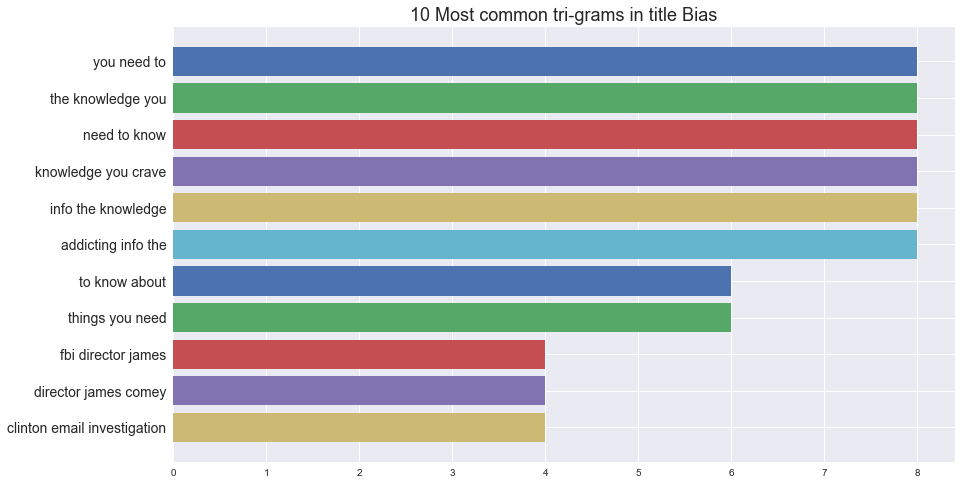

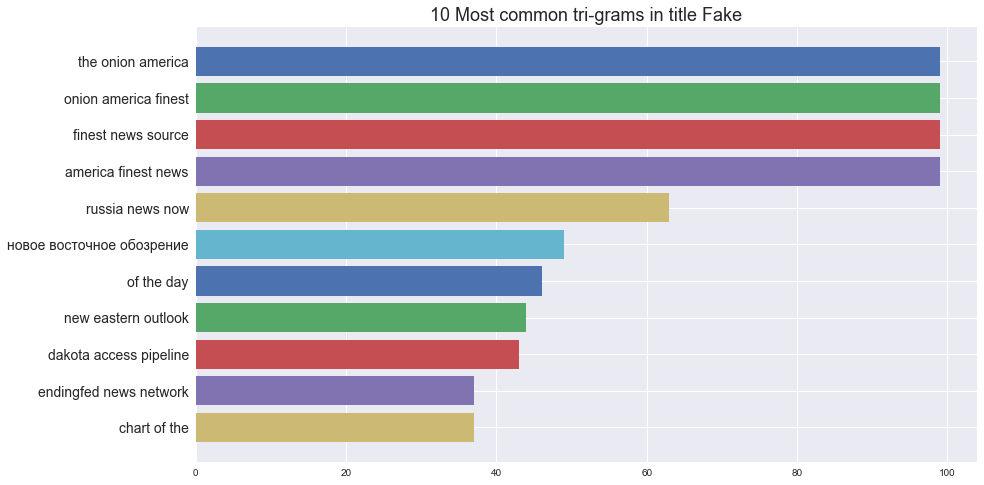

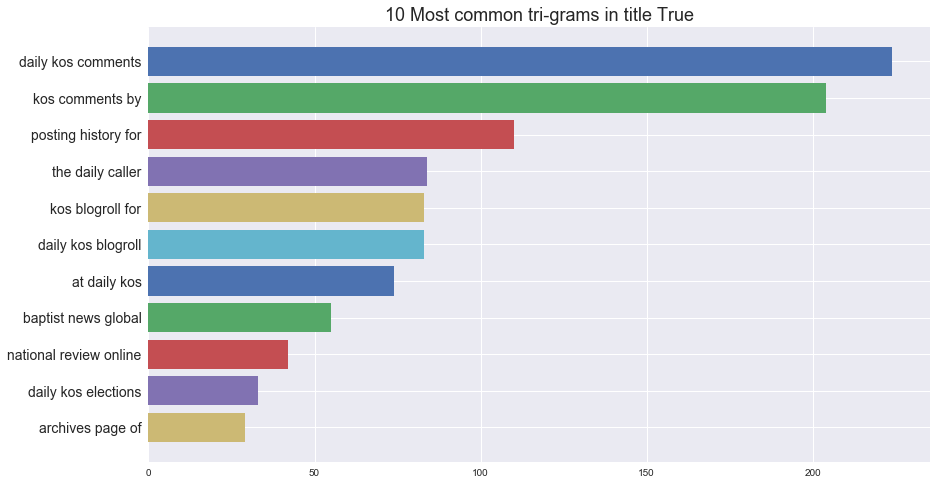

In [24]:
names = ["10 Most common tri-grams in title Bias", "10 Most common tri-grams in title Fake", "10 Most common tri-grams in title True"]
variables = [ngrams_bias, ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

**Wordclouds for titles**

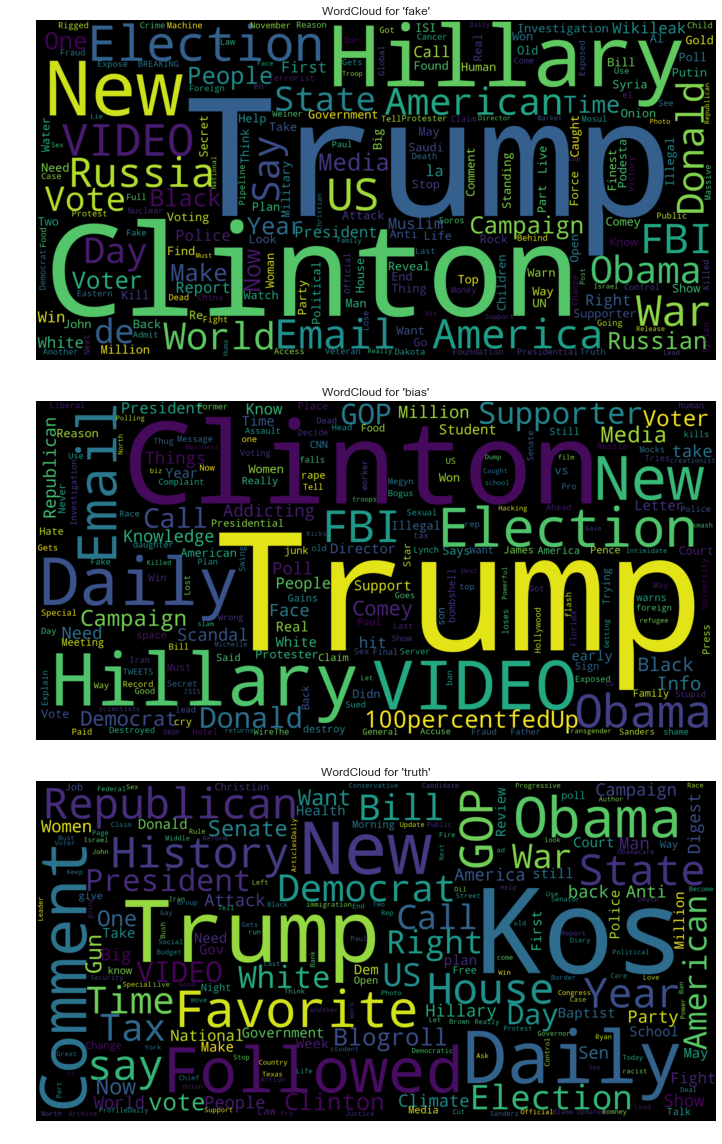

In [25]:
fig, ax = plt.subplots(3,1, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake'")


corpus_text = ''.join(news[news['type'] == 'bias']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'bias'")


corpus_text = ''.join(news[news['type'] == 'true']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[2].imshow(wordcloud, interpolation='bilinear')
ax[2].axis("off")
ax[2].set_title("WordCloud for 'truth'")

plt.tight_layout()

#### En el contenido

In [26]:
stop_words = STOPWORDS.union(set(["will", "one", "new"])) #Most common words in all

In [27]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'true']['text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'bias']['text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_bias= c.most_common(20)

In [28]:
most_common_bias

[('trump', 1513),
 ('clinton', 879),
 ('said', 487),
 ('hillary', 482),
 ('donald', 399),
 ('election', 389),
 ('campaign', 335),
 ('people', 313),
 ('president', 273),
 ('republican', 228),
 ('news', 224),
 ('voters', 221),
 ('media', 216),
 ('obama', 204),
 ('time', 201),
 ('even', 193),
 ('republicans', 193),
 ('state', 192),
 ('fbi', 190),
 ('vote', 187)]

In [29]:
most_common_truth

[('recs', 19172),
 ('trump', 17737),
 ('said', 12715),
 ('people', 12196),
 ('president', 10969),
 ('state', 10302),
 ('time', 9302),
 ('now', 9237),
 ('even', 7778),
 ('u', 7684),
 ('last', 7490),
 ('first', 7404),
 ('house', 7364),
 ('obama', 7272),
 ('us', 6989),
 ('years', 6885),
 ('republican', 6877),
 ('government', 6865),
 ('many', 6646),
 ('two', 6310)]

In [30]:
most_common_fake

[('trump', 23017),
 ('clinton', 22644),
 ('people', 19720),
 ('us', 18215),
 ('hillary', 14845),
 ('said', 14240),
 ('now', 11643),
 ('world', 11065),
 ('time', 10581),
 ('even', 10516),
 ('state', 10295),
 ('president', 10016),
 ('election', 9823),
 ('government', 9719),
 ('many', 9612),
 ('obama', 9113),
 ('war', 8843),
 ('de', 8825),
 ('u', 8441),
 ('russia', 8033)]

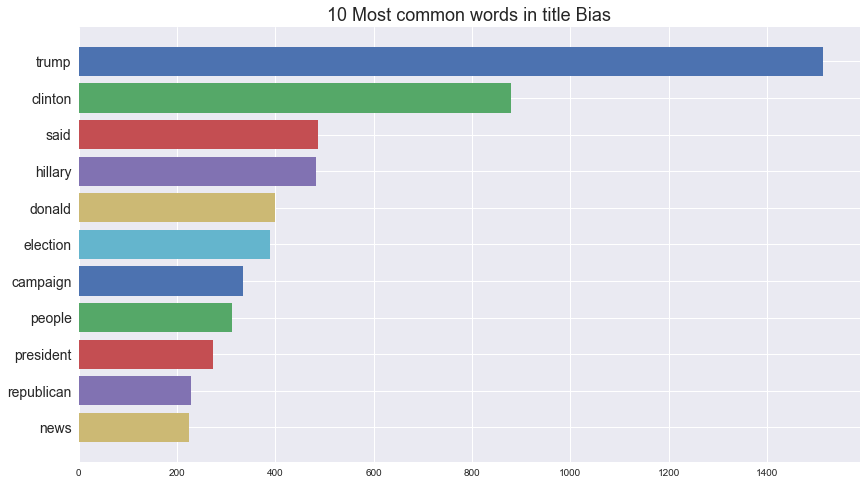

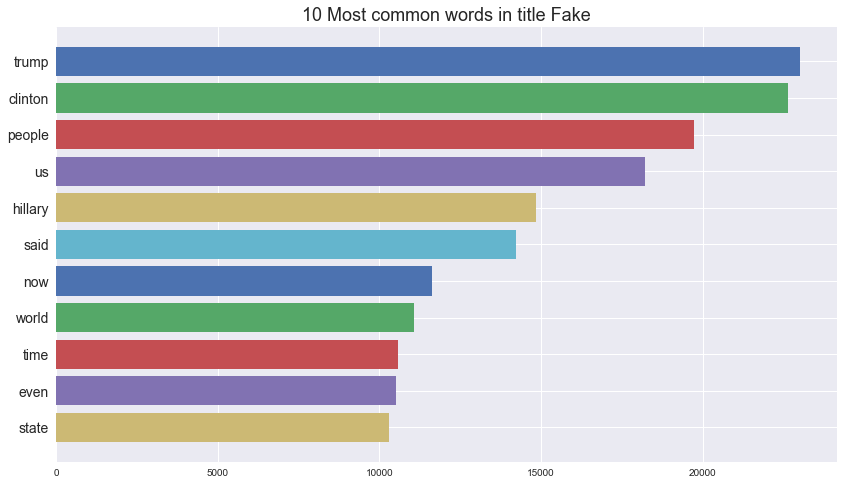

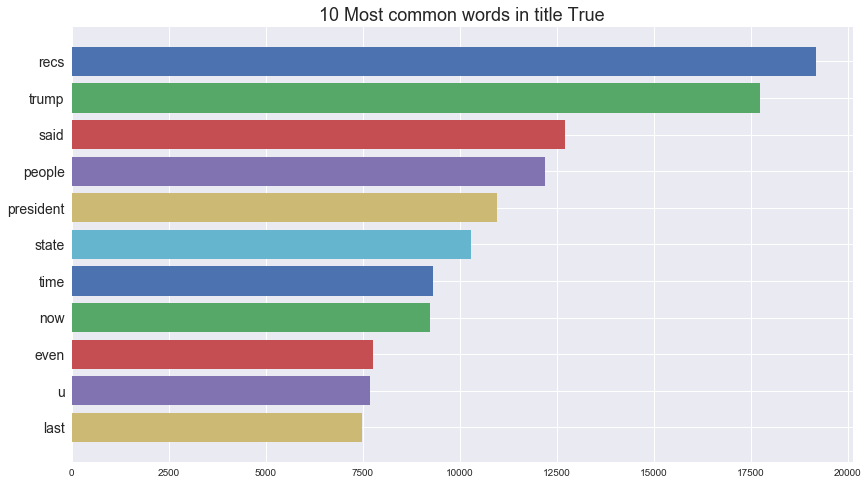

In [31]:
names = ["10 Most common words in title Bias", "10 Most common words in title Fake", "10 Most common words in title True"]
variables = [most_common_bias, most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

#### Tri-grams más usados

In [32]:
news_lite = news.head(2000) #Version reducida para que no tarde tanto

In [33]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'fake']['text'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [34]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'true']['text'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [35]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'bias']['text'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_bias = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_bias[ng_text] = ng_count

In [36]:
print("TRIGRAMS BIAS")
ngrams_bias

TRIGRAMS BIAS


{'the supreme court': 10,
 'boy needs hero': 10,
 'one of the': 8,
 'the united states': 6,
 'the director of': 6,
 'published mins ago': 6,
 'to be the': 5,
 'of hillary clinton': 5,
 'millions of new': 5,
 'in the election': 5,
 'hillary clinton and': 5,
 'director of the': 5,
 'yet alone comes': 4,
 'with his son': 4,
 'the wnd superstore': 4,
 'the significance of': 4,
 'the right wing': 4,
 'the producer of': 4,
 'the new york': 4,
 'the film boy': 4,
 'the father relationship': 4,
 'the austin institute': 4,
 'that and set': 4,
 'tale of the': 4,
 'significance of the': 4,
 'set around america': 4,
 'relationship that and': 4,
 'producer of not': 4,
 'on election day': 4,
 'of the significance': 4}

In [37]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'one of the': 237,
 'the united states': 219,
 'the white house': 168,
 'ordered mueller fired': 127,
 'out of the': 117,
 'the democratic party': 102,
 'as well as': 101,
 'according to the': 99,
 'trump ordered mueller': 96,
 'the washington post': 92,
 'the fact that': 92,
 'part of the': 91,
 'some of the': 89,
 'the end of': 82,
 'the rest of': 78,
 'in order to': 76,
 'be able to': 74,
 'president donald trump': 70,
 'on the other': 70,
 'state and local': 69,
 'in response to': 69,
 'threatened to quit': 64,
 'the recs trump': 63,
 'mueller fired but': 63,
 'fired but backed': 63,
 'counsel threatened to': 63,
 'the supreme court': 62,
 'recs trump ordered': 62,
 'not going to': 62,
 'state of the': 61}

In [38]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'the united states': 373,
 'one of the': 304,
 'as well as': 168,
 'the fact that': 162,
 'the white house': 148,
 'according to the': 145,
 'in order to': 133,
 'secretary of state': 131,
 'the clinton foundation': 103,
 'some of the': 97,
 'there is no': 93,
 'of the most': 93,
 'in the world': 93,
 'the end of': 88,
 'part of the': 87,
 'all of the': 87,
 'the middle east': 86,
 'in the united': 86,
 'new york times': 83,
 'of the united': 81,
 'this is the': 80,
 'the rest of': 78,
 'the american people': 78,
 'the new york': 77,
 'the mainstream media': 77,
 'the clinton campaign': 77,
 'out of the': 75,
 'be able to': 75,
 'in the middle': 74,
 'to do with': 69}

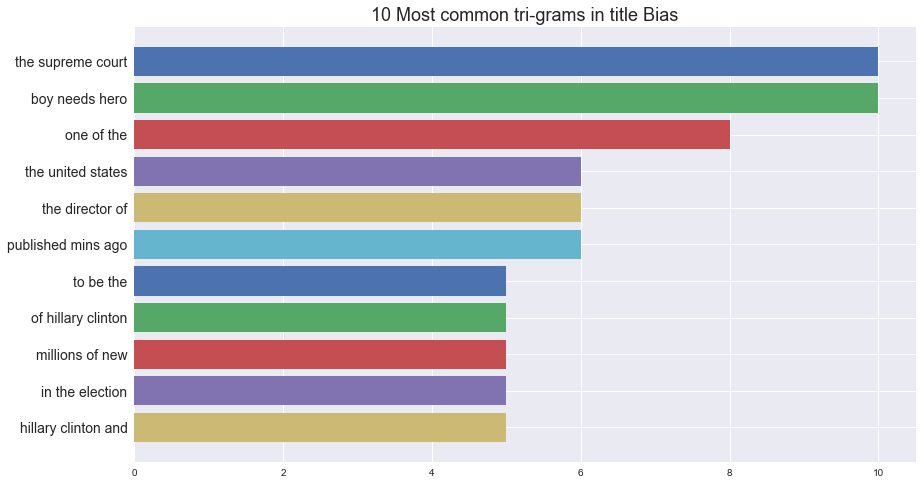

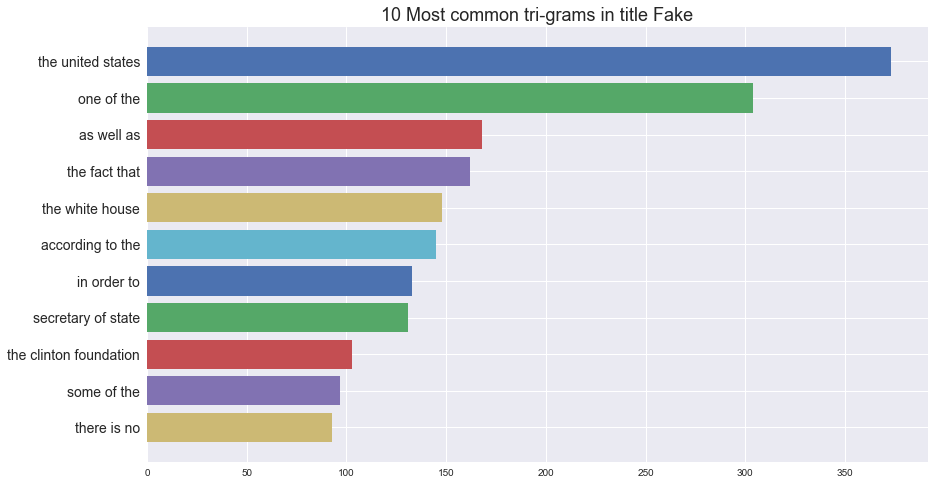

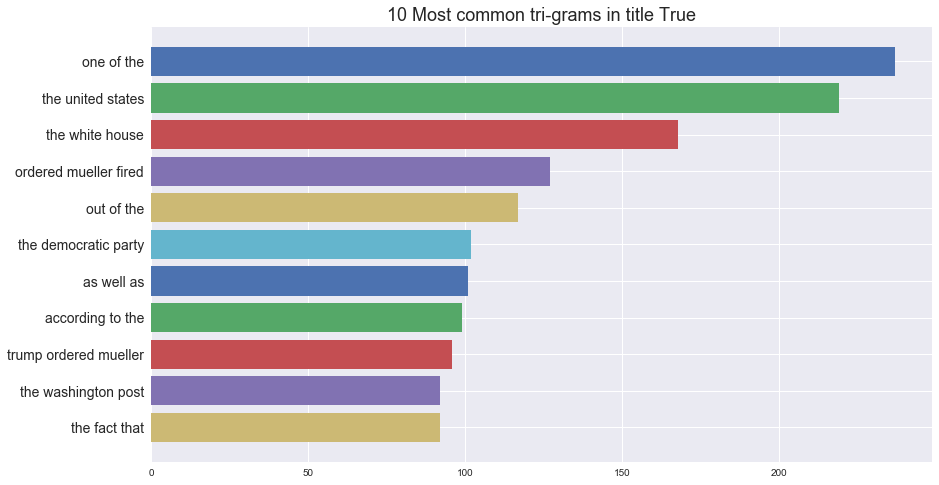

In [39]:
names = ["10 Most common tri-grams in title Bias", "10 Most common tri-grams in title Fake", "10 Most common tri-grams in title True"]
variables = [ngrams_bias, ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

Text(0.5,1,"WordCloud for 'truth'")

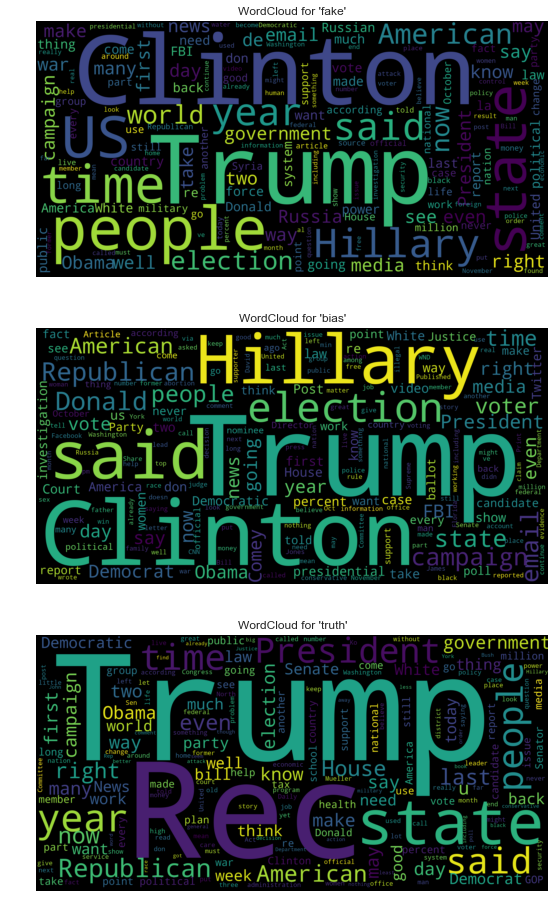

In [40]:
fig, ax = plt.subplots(3,1, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake'")


corpus_text = ''.join(news[news['type'] == 'bias']['text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'bias'")


corpus_text = ''.join(news[news['type'] == 'true']['text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[2].imshow(wordcloud, interpolation='bilinear')
ax[2].axis("off")
ax[2].set_title("WordCloud for 'truth'")

**Longitud en palabras de las noticias**

Para ello, hay que tokenizar y limpiar el texto

In [41]:
news['clean_content'] = news.swifter.apply(lambda row: clean_text(row['text']), axis=1)
news['clean_title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

Pandas Apply: 100%|██████████| 22273/22273 [00:00<00:00, 35212.28it/s]


In [42]:
news['len_content'] = news.swifter.apply(lambda row: len(row['clean_content']), axis=1)

Pandas Apply: 100%|██████████| 22273/22273 [00:00<00:00, 63922.98it/s]


Text(0.5,0.98,'')

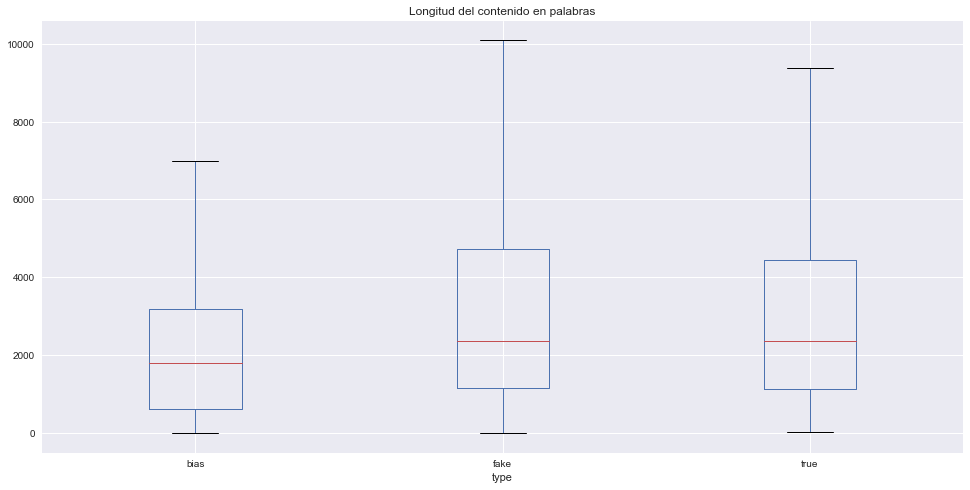

In [43]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Longitud del contenido en palabras")
plt.suptitle("")

In [44]:
news = news.drop(["clean_content", "clean_title","len_content"], axis=1)

**Longitud media de las frases**



In [45]:
corpus_text = '. '.join([i for i in news[news['type'] == 'fake']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_fake = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'true']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_truth = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'bias']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_bias = [len(tokenize(s)) for s in corpus_text]

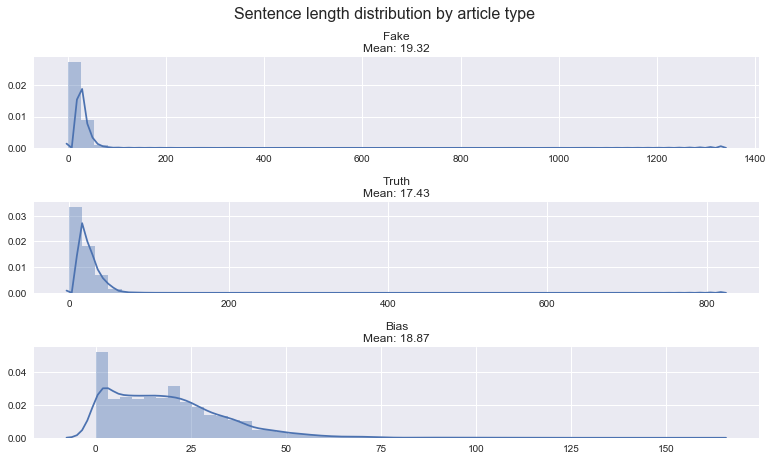

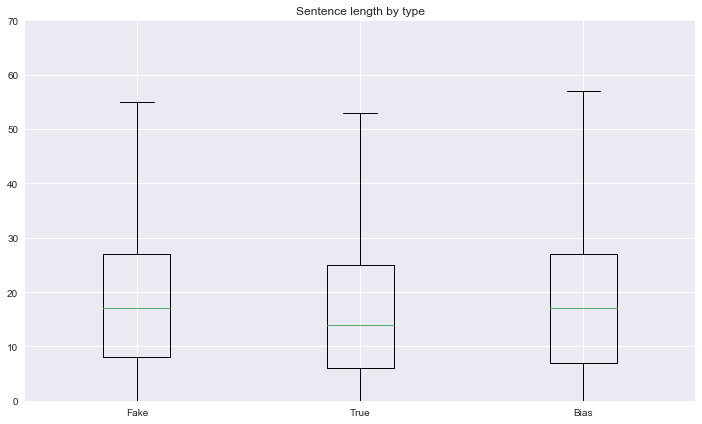

In [46]:
fig, ax = plt.subplots(3,1, figsize=(13,7))
fig.suptitle("Sentence length distribution by article type", size=16)


sns.distplot(lengths_fake, ax=ax[0])
ax[0].set_title("Fake\nMean: {0:.2f}".format(np.average(lengths_fake)))


sns.distplot(lengths_truth, ax=ax[1])
ax[1].set_title("Truth\nMean: {0:.2f}".format(np.average(lengths_truth)))


sns.distplot(lengths_bias, ax=ax[2])
ax[2].set_title("Bias\nMean: {0:.2f}".format(np.average(lengths_bias)))

fig.subplots_adjust(hspace=0.6)
plt.show()


#Boxplot
fig, ax = plt.subplots(1,1, figsize=(12,7))
plt.title("Sentence length by type")
plt.ylim((0,70))
plt.boxplot([lengths_fake, lengths_truth, lengths_bias], 
            labels=['Fake', 'True', 'Bias'])
plt.show()

**Longitud en frases de las noticias**

In [47]:
news['len_content'] = news.swifter.apply(lambda row: len(row['text'].split(". ")), axis=1)

Pandas Apply: 100%|██████████| 22273/22273 [00:00<00:00, 36408.30it/s]


Text(0.5,0.98,'')

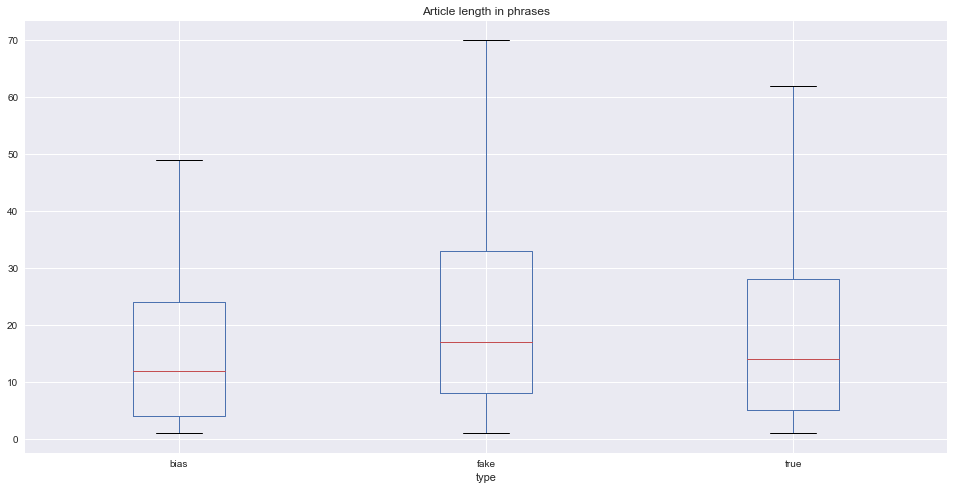

In [48]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Article length in phrases")
plt.suptitle("")

**Signos de exclamación/interrogación por tipos de noticias**

In [49]:
news['len_content'] = news.text.str.count("!|\?")

Text(0.5,0.98,'')

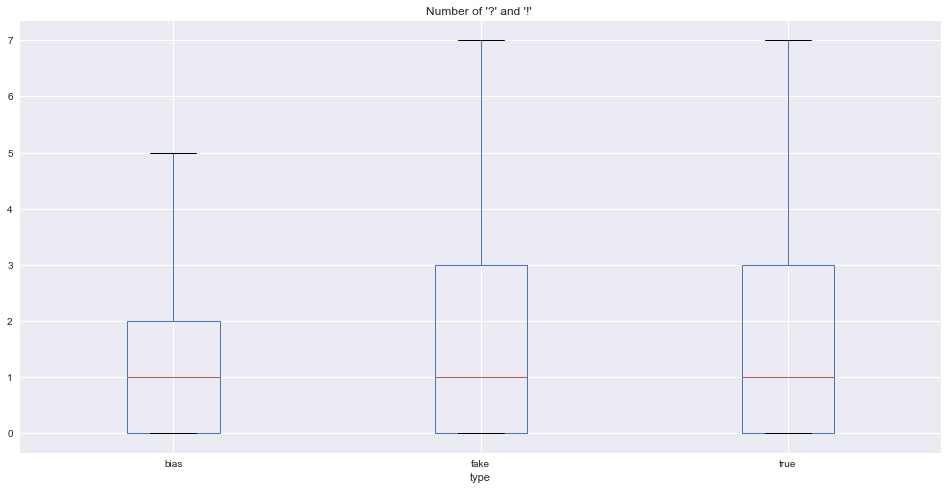

In [50]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Number of '?' and '!' ")
plt.suptitle("")

In [51]:
news=news.drop(['len_content'], axis=1)

## Análisis psicológico

Analizar las noticias por uso de personas:

* Primera persona: *I, me, my, mine, we, usk our, ours*
* Segunda persona: *you, you, your, yours*
* Tercera persona: *he, she, his, her, him, his, hers, they, them, their, theirs*

In [52]:
def count_person_forms(text, person):
    """
    Cuenta las ocurrencias de los tokens de person en el texto
    """
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter       

Pandas Apply: 100%|██████████| 22273/22273 [00:08<00:00, 2685.99it/s]


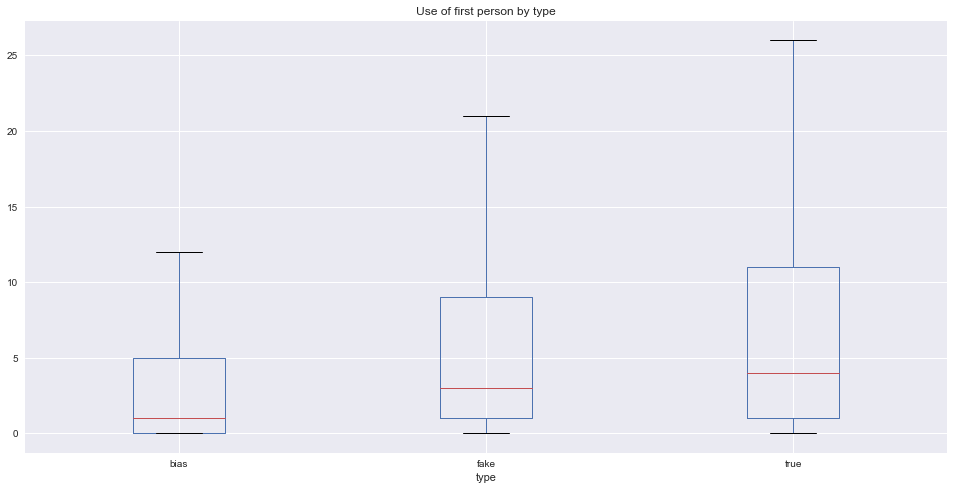

In [53]:
first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
second_person = ["you", "your", "yours"]

news['first_person'] = news.swifter.apply(lambda row: count_person_forms(row['text'], first_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['first_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of first person by type")
fig.suptitle("")
plt.show()

In [54]:
news.groupby('type')['first_person'].mean()

type
bias    4.302260
fake    8.897139
true    9.312800
Name: first_person, dtype: float64

Pandas Apply: 100%|██████████| 22273/22273 [00:07<00:00, 3174.36it/s]


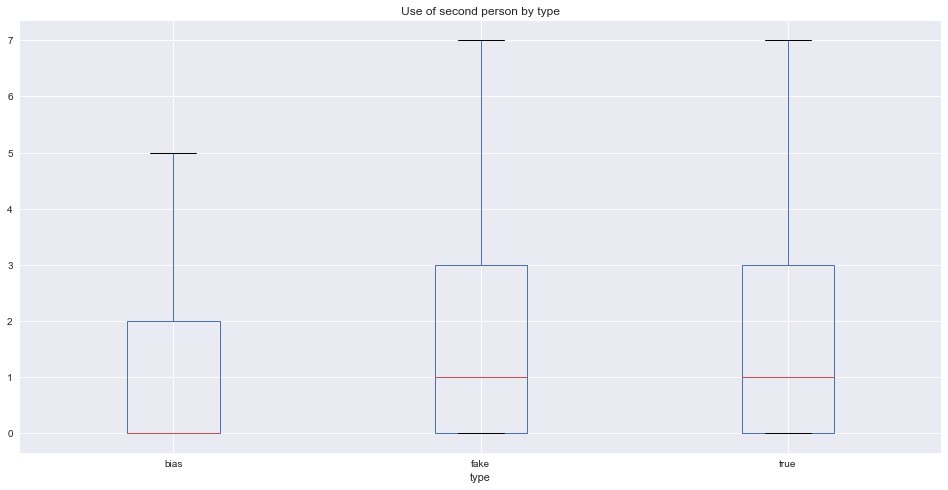

In [55]:
news['second_person'] = news.swifter.apply(lambda row: count_person_forms(row['text'], second_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['second_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of second person by type")
fig.suptitle("")
plt.show()

In [56]:
news=news.drop(['first_person'], axis=1)
news=news.drop(['second_person'], axis=1)

## Análisis de sentimiento

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [58]:
def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

In [59]:
news['sent'] = news.swifter.apply(lambda r: classify_sentiment(r['text']), axis=1)

Pandas Apply: 100%|██████████| 22273/22273 [05:42<00:00, 65.09it/s]


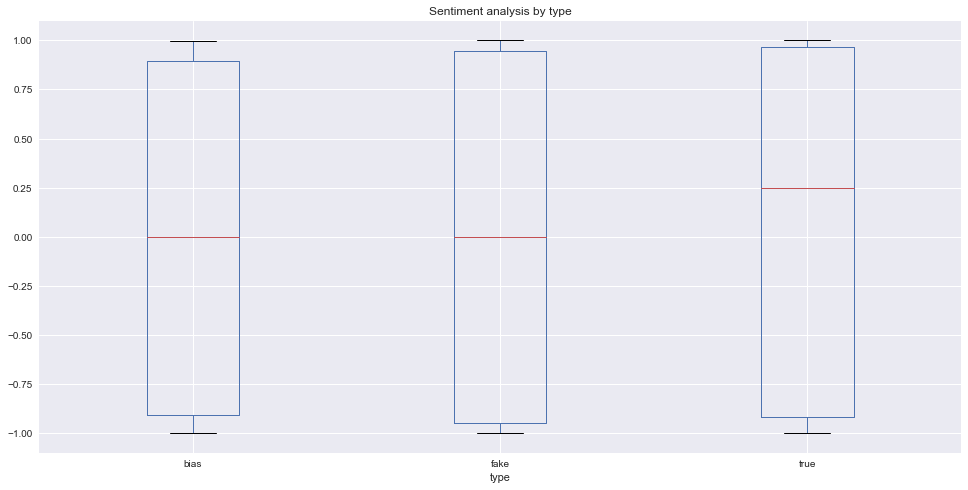

In [60]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['sent'], by='type', ax=ax, showfliers=False)
ax.set_title("Sentiment analysis by type")
fig.suptitle("")
plt.show()

## Análisis de diversidad de vocabulario

$ l = \frac {|t|}{|T|}$

Siendo
* $t$ el texto
* $T$ el conjunto de palabras (sin repetición) en el texto

In [61]:
def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    if len(text) == 0:
        return 0
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

In [62]:
news['lexical_diver'] = news.swifter.apply(lambda r: lexical_diversity(r['text']), axis=1)

Pandas Apply: 100%|██████████| 22273/22273 [00:06<00:00, 3428.31it/s]


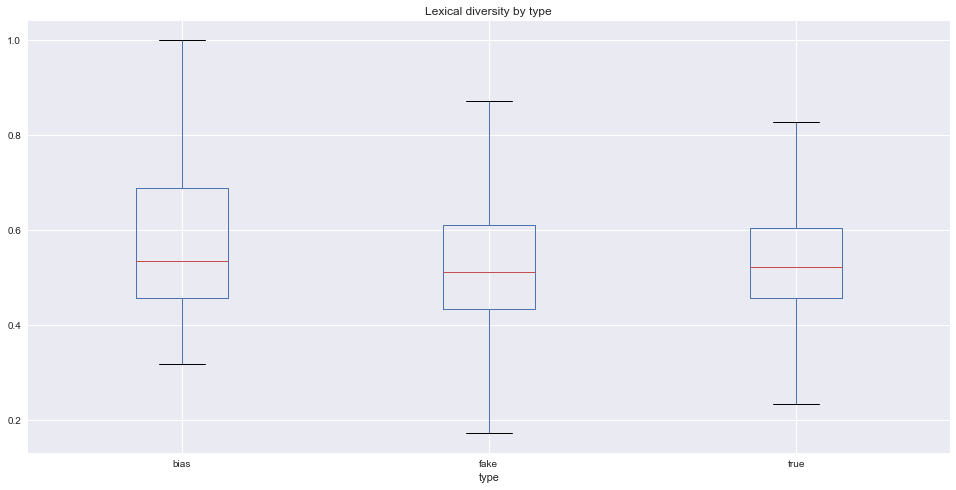

In [63]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = news.boxplot(column=['lexical_diver'], by='type', ax=ax, showfliers=False)
ax.set_title("Lexical diversity by type")
fig.suptitle("")
plt.show()

In [64]:
news.groupby('type')['lexical_diver'].mean()

type
bias    0.576765
fake    0.531831
true    0.549673
Name: lexical_diver, dtype: float64